- in the members_nll part of PoE objective function we should probably reuse individual likelihoods from the product_nll term, or? in the current implementation, we have "standard" categorical distribution in members_nll while in product_nll we have hard_ovr distribution...

- why for alpha=1.0 (in the code) the performance of ens and prod is not more or less the same for M=1 (i.e. ensembles of size 1)? the performance gap is actually the biggest for alpha=1, why??
- study pretraining in more details: have a plot where you first pretrain DE for 50 epochs and then switch to PoE objective (do it once with alpha=0, i.e. so only have product in the objective function, and once with alpha=0.5) for various types of epochs (10, 20, 30, 40, 50)
- stochastic sampling of ensemble members during training

DONE:
- plot effect of alpha and pretraining
- random seed in ensembles -> are we using different seeds for each member? YES
- study magnitudes of terms in objective function (would imagine for that sum of expert likelihoods is larger compared to PoE likelihood), how does this impact the choice of alpha?

In [1]:
import sys; sys.path.insert(0, "../../")

import os
import logging
from functools import partial

from jax import random
from torchvision import transforms
import wandb
from flax.training.checkpoints import save_checkpoint, restore_checkpoint

from src.models import make_Hard_OvR_Ens_loss as make_prod_loss
from src.models import make_Hard_OvR_Ens_MNIST_plots as make_plots
from src.models import make_Cls_Ens_loss as make_ens_loss
from src.models.hard_ovr_prod import MembersLL
from src.data import get_image_dataset, NumpyLoader
from src.utils.training import setup_training, train_loop
from src.utils.notebook_metrics import *
from experiments.configs.mnist_hard_ovr_classification import get_config

from operator import itemgetter
from  functools import partial
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go

2022-10-17 16:51:14.582798: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:51:15.227969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:51:15.228049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:51:15.228057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'mnist_performance_gap_investigation.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

In [4]:
config = get_config()

In [5]:
ens_config = config.copy_and_resolve_references()
ens_config.model_name = 'Cls_Ens'
del ens_config.β_schedule

### 1) load datasets

In [6]:
train_dataset, _, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
ens_train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
ens_val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)

train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)

### 2) model training

In [7]:
RANDOM_SEEDS = [0]
ALPHAS = [0., 0.2, 0.4, 0.5, 0.6, 0.8 ,1.]
# ALPHAS = [0., 1/6, 0.5, 5/6, 1.]
# ALPHAS = [0.5]
RECOMPUTE_ENS = False
# MEMBERS_LL = MembersLL.soft_ovr
MEMBERS_LL = MembersLL.softmax
FINE_TUNE_EPOCHS = [0, 2, 10, 25]

config.model.members_ll_type = MEMBERS_LL.value

In [8]:
for i in RANDOM_SEEDS:
    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    init_x = train_dataset[0][0]
    init_y = train_dataset[0][1]

    ens_model, state = setup_training(ens_config, setup_rng, init_x, init_y)

    if RECOMPUTE_ENS:
        _, ens_state = train_loop(
            ens_model, state, ens_config, rng, make_ens_loss, make_ens_loss, ens_train_loader, ens_val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': 'Data augmentation',
                # 'tags': ['MNIST testing'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/ens_model_{i}', ens_state, 1, overwrite=True)
#     else:
#         ens_state = restore_checkpoint(f'dynNN_redux/ens_model_{i}', 1)

    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    
    for alpha in ALPHAS:
        # for pretrained in [False, True]:
        for pretrained in [True]:
            for ft in FINE_TUNE_EPOCHS:
                
                config.alpha = alpha
                config.pretrained = pretrained
                if ft is not None:
                    config.epochs = ft
            
                prod_model, state = setup_training(config, setup_rng, init_x, init_y)

                if pretrained:
                    state = state.replace(params=ens_state.params)
                    state = state.replace(model_state=ens_state.model_state)

                _, prod_state = train_loop(
                        prod_model, state, config, rng, 
                    partial(make_prod_loss, per_member_loss=alpha), 
                    partial(make_prod_loss, per_member_loss=alpha), 
                    train_loader, val_loader,
                    # test_loader,
                    wandb_kwargs={
                        'mode': 'online',
                        # 'notes': 'pre-trained',
                        # 'tags': ['MNIST testing', 'pre-trained'],
                    },
                    # plot_fn=make_plots,
                    # plot_freq=1,
                )

                pretrained_str = "_pretrained" if pretrained else ""
                finetuned = f"_finetuned{ft}" if ft is not None else ""
                save_checkpoint(f'dynNN_redux/prod_model_{i}_{alpha}{pretrained_str}_{MEMBERS_LL.value}{finetuned}', 
                                prod_state, 1, overwrite=True)

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

2022-10-17 16:51:30.003883: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:51:30.528369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:51:30.528433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:51:30.528441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 0.80582, val loss: 0.34854, train err: 0.1849, val err: 0.0840, lr: 0.00360, prod_nll: 1.00000', ', members_nll: 4.02909')
Best val_err
epoch:   2 - ('train loss: 0.31676, val loss: 0.26819, train err: 0.0730, val err: 0.0658, lr: 0.00420, prod_nll: 1.00000', ', members_nll: 1.58378')
Best val_err
epoch:   3 - ('train loss: 0.24675, val loss: 0.22564, train err: 0.0559, val err: 0.0568, lr: 0.00480, prod_nll: 1.00000', ', members_nll: 1.23373')
Best val_err
epoch:   4 - ('train loss: 0.20621, val loss: 0.20045, train err: 0.0470, val err: 0.0488, lr: 0.00540, prod_nll: 1.00000', ', members_nll: 1.03107')
Best val_err
epoch:   5 - ('train loss: 0.17647, val loss: 0.17530, train err: 0.0392, val err: 0.0443, lr: 0.00600, prod_nll: 1.00000', ', members_nll: 0.88235')
Best val_err
epoch:   6 - ('train loss: 0.15444, val loss: 0.15906, train err: 0.0342, val err: 0.0407, lr: 0.00660, prod_nll: 1.00000', ', members_nll: 0.77222')
Best val_err
epoch:   7 - ('train l

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

2022-10-17 16:54:23.173479: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:54:23.735836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:54:23.735925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:54:23.735934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


0it [00:00, ?it/s]

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

2022-10-17 16:54:31.561513: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:54:32.123808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:54:32.123873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:54:32.123881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 0.07317, val loss: 0.28124, train err: 0.0034, val err: 0.0215, β: 2.1141, lr: 0.00360, prod_nll: 0.03166', ', members_nll: 0.11469')
Best val_err
epoch:   2 - ('train loss: 0.07128, val loss: 0.27901, train err: 0.0027, val err: 0.0213, β: 2.1391, lr: 0.00420, prod_nll: 0.02145', ', members_nll: 0.12111')
Best val_err


+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

2022-10-17 16:55:12.259997: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:55:12.776745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:55:12.776809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:55:12.776817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/10 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 0.07317, val loss: 0.28124, train err: 0.0034, val err: 0.0215, β: 2.1141, lr: 0.00360, prod_nll: 0.03166', ', members_nll: 0.11469')
Best val_err
epoch:   2 - ('train loss: 0.07128, val loss: 0.27901, train err: 0.0027, val err: 0.0213, β: 2.1391, lr: 0.00420, prod_nll: 0.02145', ', members_nll: 0.12111')
Best val_err
epoch:   3 - ('train loss: 0.07075, val loss: 0.27738, train err: 0.0027, val err: 0.0218, β: 2.1695, lr: 0.00480, prod_nll: 0.01776', ', members_nll: 0.12373')
Best val_err
epoch:   4 - ('train loss: 0.06809, val loss: 0.27543, train err: 0.0027, val err: 0.0215, β: 2.2065, lr: 0.00540, prod_nll: 0.01543', ', members_nll: 0.12075')
Best val_err
epoch:   5 - ('train loss: 0.06639, val loss: 0.27225, train err: 0.0023, val err: 0.0212, β: 2.2513, lr: 0.00600, prod_nll: 0.01364', ', members_nll: 0.11915')
Best val_err
epoch:   6 - ('train loss: 0.06341, val loss: 0.27699, train err: 0.0022, val err: 0.0218, β: 2.3058, lr: 0.00660, prod_nll: 0.012

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

2022-10-17 16:56:16.114420: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:56:16.666773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:56:16.666880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-17 16:56:16.666889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/25 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 0.07317, val loss: 0.28124, train err: 0.0034, val err: 0.0215, β: 2.1141, lr: 0.00360, prod_nll: 0.03166', ', members_nll: 0.11469')
Best val_err
epoch:   2 - ('train loss: 0.07128, val loss: 0.27901, train err: 0.0027, val err: 0.0213, β: 2.1391, lr: 0.00420, prod_nll: 0.02145', ', members_nll: 0.12111')
Best val_err
epoch:   3 - ('train loss: 0.07075, val loss: 0.27738, train err: 0.0027, val err: 0.0218, β: 2.1695, lr: 0.00480, prod_nll: 0.01776', ', members_nll: 0.12373')
Best val_err
epoch:   4 - ('train loss: 0.06809, val loss: 0.27543, train err: 0.0027, val err: 0.0215, β: 2.2065, lr: 0.00540, prod_nll: 0.01543', ', members_nll: 0.12075')
Best val_err
epoch:   5 - ('train loss: 0.06639, val loss: 0.27225, train err: 0.0023, val err: 0.0212, β: 2.2513, lr: 0.00600, prod_nll: 0.01364', ', members_nll: 0.11915')
Best val_err
epoch:   6 - ('train loss: 0.06341, val loss: 0.27699, train err: 0.0022, val err: 0.0218, β: 2.3058, lr: 0.00660, prod_nll: 0.012

## 3) metrics

In [9]:
X_test, y_test = list(zip(*test_loader.dataset))

In [10]:
s = set(range(config.model.size))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

### utils functions

In [11]:
def compute_metrics(model, model_name, state, random_seed):
    pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False,
            method=model.ens_logits
        )
    logits = jax.vmap(
        pred_fun, axis_name="batch"
    )(jnp.array(X_test))

    rows = []
    for indices in power_set:
        n_members = len(indices)
        logits_ = logits[:, indices, :]

        if 'prod' in model_name:
            entropies = jax.vmap(ovr_entropy)(logits_)
            nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
            infs = jnp.isinf(nlls_)
            print(f"dropping {infs.sum()} infs for prod of {n_members}")
            nlls = nlls_[~infs]
            briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
            errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))
        elif 'ens' in model_name:
            entropies = jax.vmap(categorical_entropy)(logits_)
            nlls_ = jax.vmap(categorical_nll)(logits_, jnp.array(y_test))
            infs = jnp.isinf(nlls_)
            if infs.sum() > 0:
                print(f"dropping {infs.sum()} infs for Ens of {n_members}")
                print(logits_[infs])
                print(jnp.array(y_test)[infs])
            nlls = nlls_[~infs]
            briers = jax.vmap(categorical_brier)(logits_, jnp.array(y_test))
            errs = jax.vmap(categorical_err)(logits_, jnp.array(y_test))
        else:
            raise ValueError()
            
        results = {'model_name': model_name,
                    'n_members': n_members,
                    'random_seed': random_seed,
                    'H': entropies.mean(),
                    'nll': nlls.mean(),
                    'err': errs.mean(),
                    'brier': briers.mean(),
                }

        rows.append(results)
    return rows

In [12]:
def generate_name(model_type, alpha, pretrained, members_ll, finetune_epochs, i):
    if model_type == "ens":
        return f"{model_type}_model_{i}"
    else:
        pretrained = "_pretrained" if pretrained else ""
        members_ll = f"_{members_ll}"
        finetuned = f"_finetuned{finetune_epochs}" if finetune_epochs is not None else ""
        return f"{model_type}_model_{i}_{alpha}{pretrained}{members_ll}{finetuned}"

In [13]:
def metrics_df(config, models):
    results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'err', 'brier', 'nll'])
    
    for model_type, alpha, pretrained, members_ll, ft_epochs in models:
        for i in range(1):
            model_name = generate_name(model_type, alpha, pretrained, members_ll, ft_epochs, i)
            print(model_name)
            model = prod_model if model_type == 'prod' else ens_model
            state = restore_checkpoint(f'dynNN_redux/{model_name}', 1)

            results = compute_metrics(model, model_name, state, i)
            results_df = pd.concat([
                results_df,
                pd.DataFrame(results)],
                ignore_index=True
            )
            
    min_mse_df = results_df[results_df.n_members == config.model.size][['model_name', 'random_seed', 'err', 'nll', 'brier']].rename(
    columns={'err': 'final_err', 'nll': 'final_nll', 'brier': 'final_brier'})
    
    tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
    tmp_df['err_diff'] = tmp_df['err'] - tmp_df['final_err'] 
    tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
    tmp_df['brier_diff'] = tmp_df['brier'] - tmp_df['final_brier'] 
    
    agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'err_diff': ['mean', 'std', 'count'],
    'err': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
    'brier_diff': ['mean', 'std', 'count'],
    'brier': ['mean', 'std', 'count'],
})
    return agg_df

In [14]:
METRICS = ["err", "H", "nll", "brier"]

### effect of pretraining
here we use members_ll = softmax

In [87]:
models = [('ens', None, None, None)] + \
            [('prod', alpha, pretrained, None) \
             for alpha in ALPHAS \
             for pretrained in [False, True]]

In [88]:
metrics_alpha_experiment = metrics_df(config, models)

ens_model_0
prod_model_0_0.0
dropping 331 infs for prod of 1
dropping 420 infs for prod of 1
dropping 315 infs for prod of 1
dropping 343 infs for prod of 1
dropping 358 infs for prod of 1
dropping 679 infs for prod of 2
dropping 574 infs for prod of 2
dropping 592 infs for prod of 2
dropping 598 infs for prod of 2
dropping 674 infs for prod of 2
dropping 704 infs for prod of 2
dropping 716 infs for prod of 2
dropping 592 infs for prod of 2
dropping 592 infs for prod of 2
dropping 608 infs for prod of 2
dropping 885 infs for prod of 3
dropping 904 infs for prod of 3
dropping 911 infs for prod of 3
dropping 798 infs for prod of 3
dropping 792 infs for prod of 3
dropping 810 infs for prod of 3
dropping 909 infs for prod of 3
dropping 906 infs for prod of 3
dropping 927 infs for prod of 3
dropping 811 infs for prod of 3
dropping 1081 infs for prod of 4
dropping 1076 infs for prod of 4
dropping 1094 infs for prod of 4
dropping 982 infs for prod of 4
dropping 1094 infs for prod of 4
droppin

dropping 141 infs for prod of 1
dropping 11 infs for prod of 1
dropping 192 infs for prod of 2
dropping 139 infs for prod of 2
dropping 230 infs for prod of 2
dropping 140 infs for prod of 2
dropping 105 infs for prod of 2
dropping 203 infs for prod of 2
dropping 107 infs for prod of 2
dropping 144 infs for prod of 2
dropping 17 infs for prod of 2
dropping 143 infs for prod of 2
dropping 192 infs for prod of 3
dropping 267 infs for prod of 3
dropping 194 infs for prod of 3
dropping 230 infs for prod of 3
dropping 141 infs for prod of 3
dropping 230 infs for prod of 3
dropping 204 infs for prod of 3
dropping 108 infs for prod of 3
dropping 203 infs for prod of 3
dropping 146 infs for prod of 3
dropping 267 infs for prod of 4
dropping 194 infs for prod of 4
dropping 267 infs for prod of 4
dropping 230 infs for prod of 4
dropping 204 infs for prod of 4
dropping 267 infs for prod of 5
prod_model_0_0.6_pretrained
dropping 60 infs for prod of 1
dropping 72 infs for prod of 1
dropping 17 infs

In [92]:
metrics_alpha_experiment["err"]["mean"].loc["prod_model_0_0.0"]

n_members
1    0.37010
2    0.12611
3    0.09597
4    0.10484
5    0.11940
Name: mean, dtype: float64

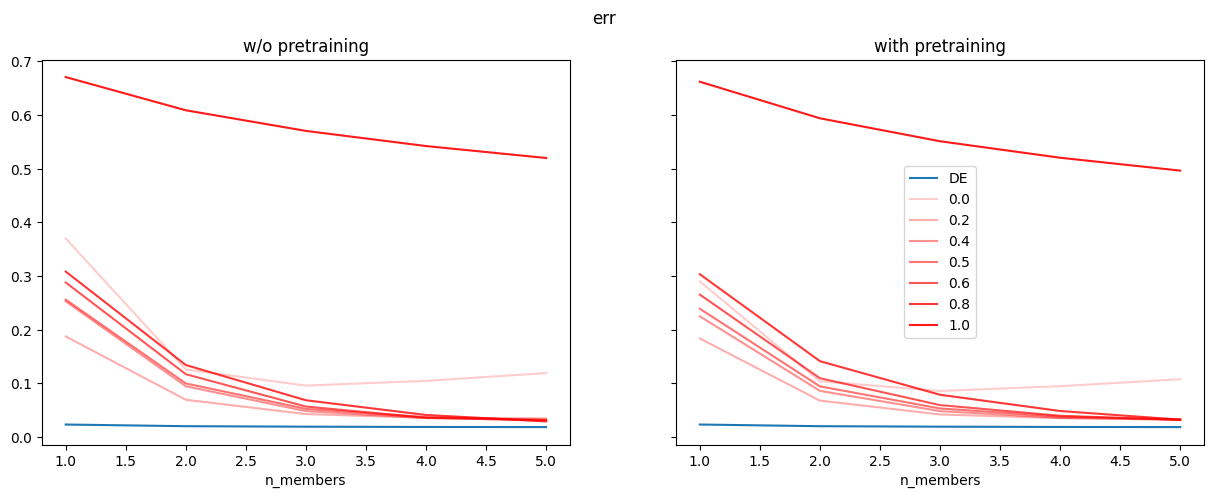

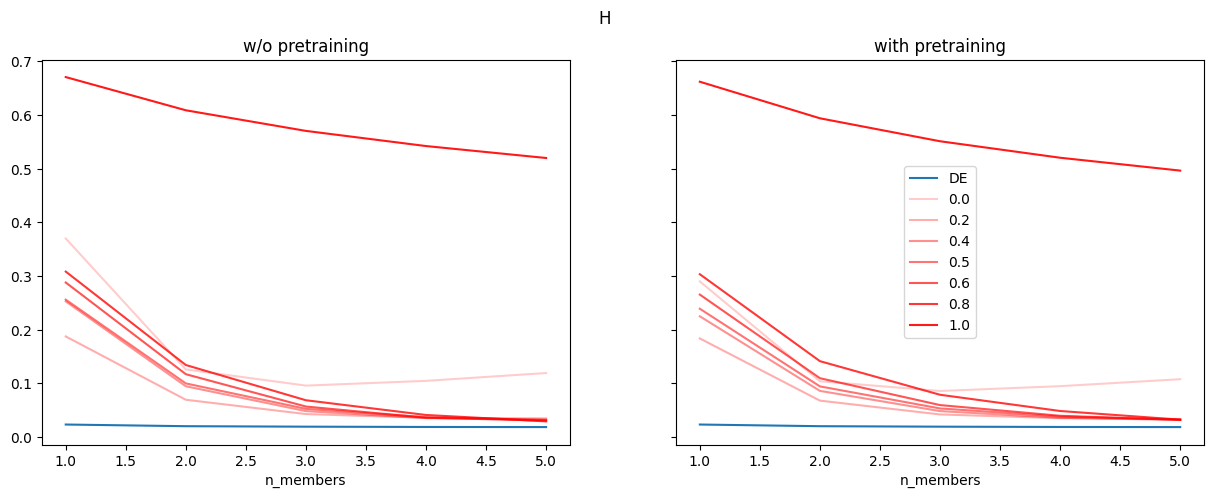

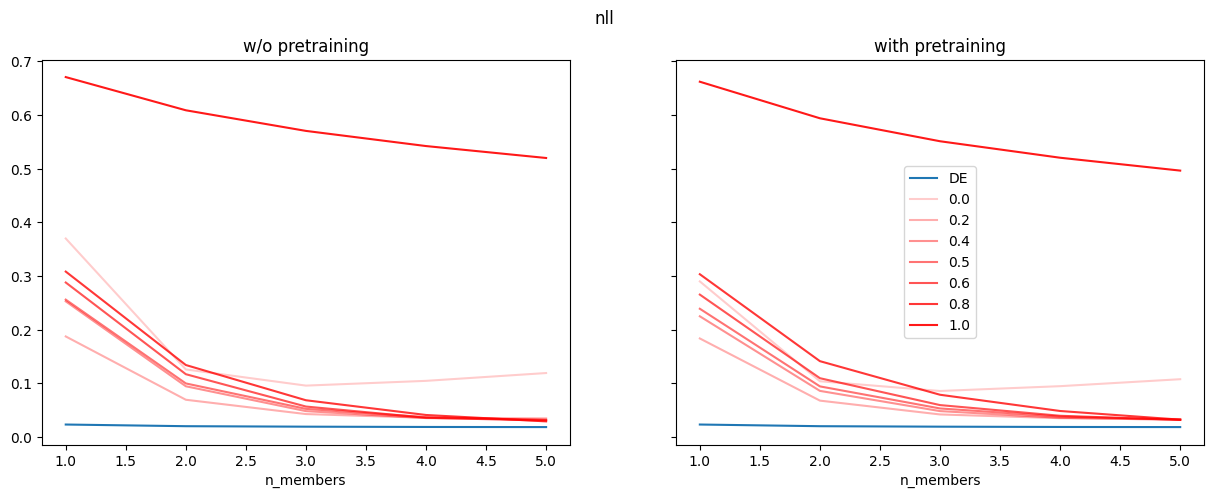

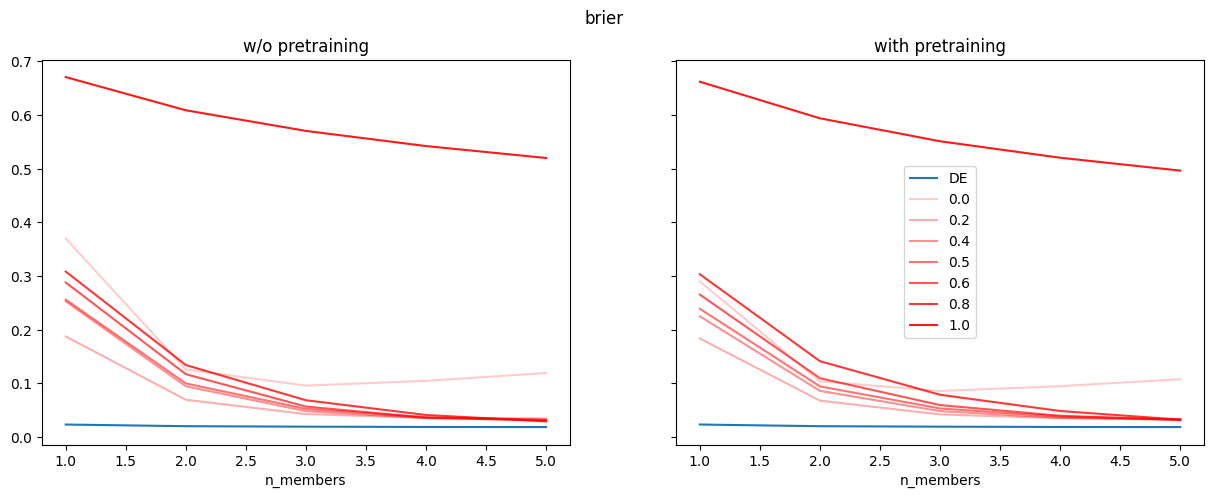

In [95]:
for metric in METRICS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

    metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

    alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
    for i, alpha in enumerate(ALPHAS):
        metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}', :].plot(ax=axes[0], 
                                                                   label=alpha, 
                                                                   color="red", 
                                                                   alpha=alpha_plot[i])
        metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].plot(ax=axes[1], 
                                                                              label=alpha,
                                                                              color="red", 
                                                                              alpha=alpha_plot[i])

    axes[0].set_title("w/o pretraining")
    axes[1].set_title("with pretraining")

    fig.suptitle(metric)
    plt.legend()
    plt.show()

In [96]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("with pretraining", "w/o pretraining"))

fig.add_trace(
    go.Scatter(x=list(metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].index), 
               y=list(metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].values), 
               name="DE", marker = {'color' : 'blue'}),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(x=list(metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].index),
               y=list(metrics_alpha_experiment["err"]["mean"].loc['ens_model_0', :].values),
               showlegend=False, name="DE", marker = {'color' : 'blue'}),
    row=1, col=2, 
)

alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
for i, alpha in enumerate(ALPHAS):
    fig.add_trace(
    go.Scatter(x=list(metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}', :].index), 
               y=list(metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}', :].values), 
               name=alpha, marker = {'color' : 'red'}, opacity=alpha_plot[i]),
    row=1, col=1,
)

    fig.add_trace(
        go.Scatter(x=list(metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].index),
                   y=list(metrics_alpha_experiment["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].values), 
                   name=alpha, marker = {'color' : 'red'}, showlegend=False, opacity=alpha_plot[i]),
        row=1, col=2, 
    )
    
fig.update_layout(height=600, width=1200)
fig.show()

### effect of aligning members' likelihood between training and test time inference

In [ ]:
models = [('ens', None, None, None)] + \
            [('prod', alpha, pretrained, members_ll) \
             for alpha in ALPHAS \
             for pretrained in [False] \
             for members_ll in [MembersLL.soft_ovr.value, MembersLL.softmax.value]]

In [ ]:
metrics_members_ll_experiment = metrics_df(config, models)

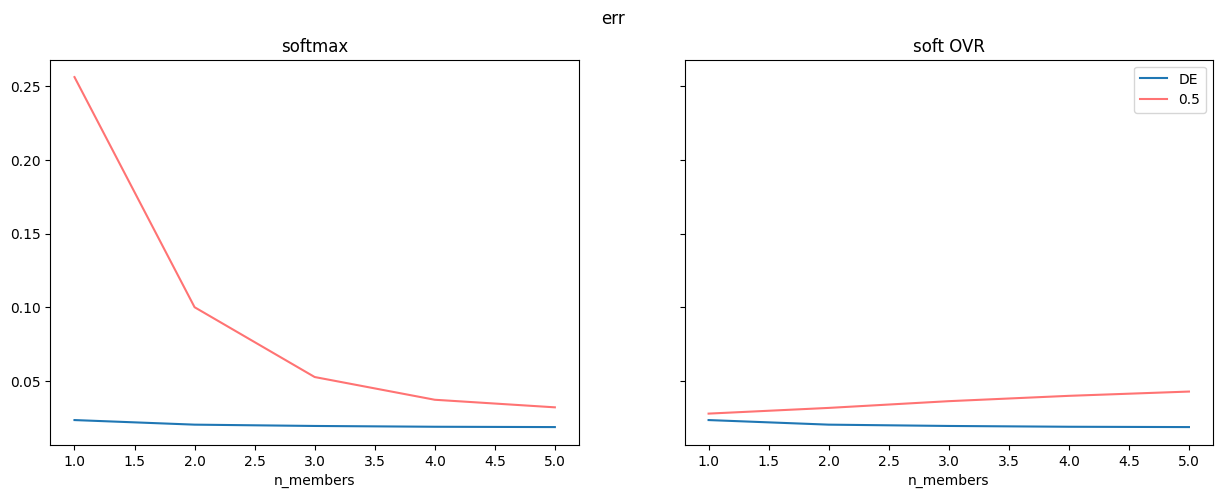

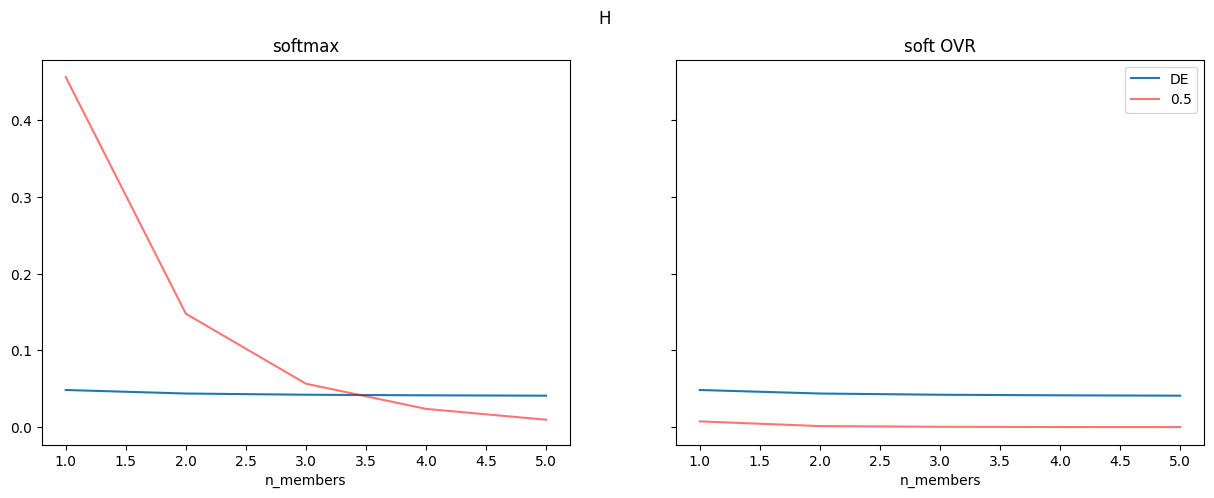

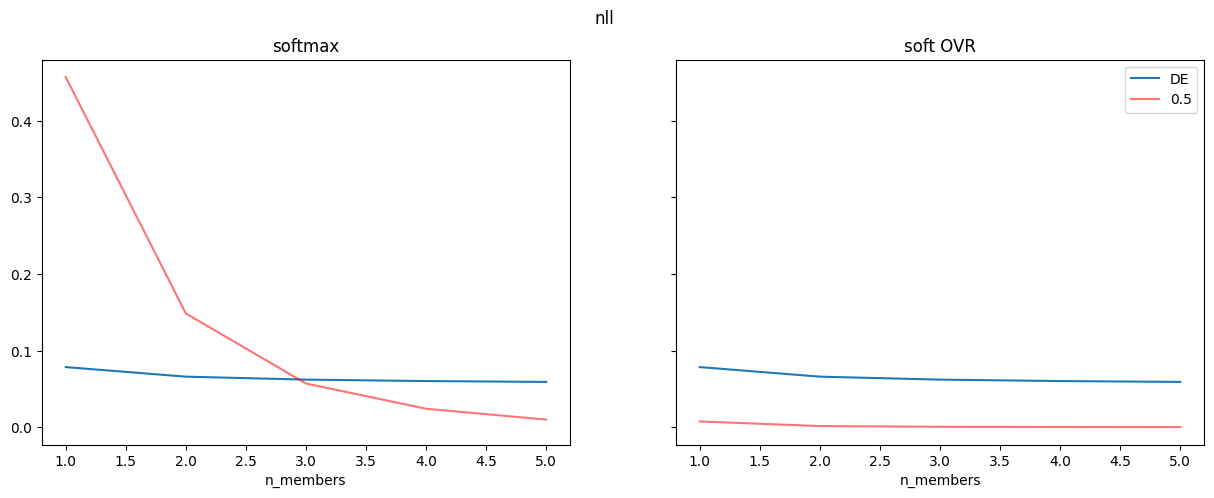

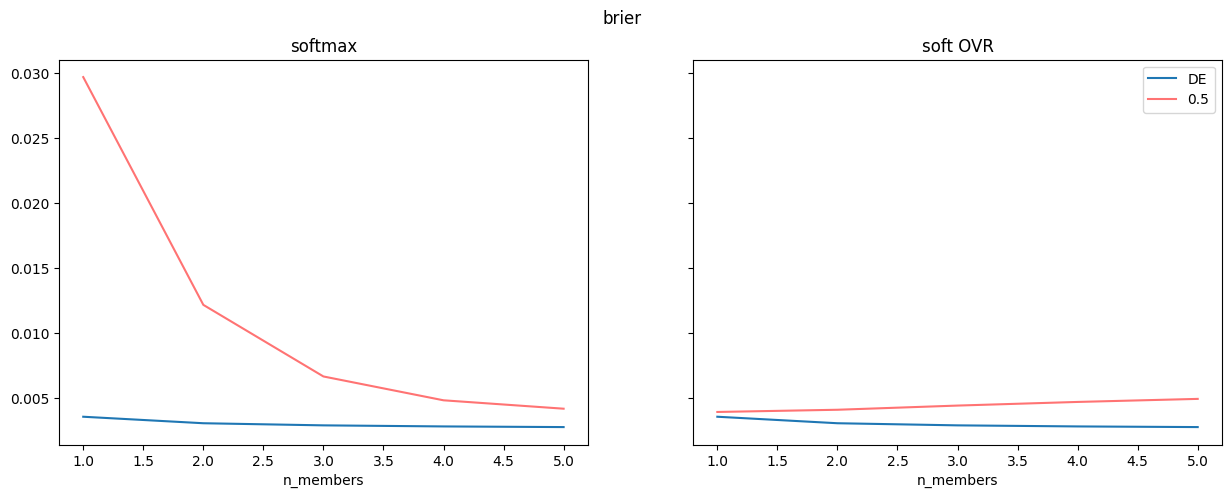

In [84]:
for metric in METRICS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

    metrics_members_ll_experiment[metric]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    metrics_members_ll_experiment[metric]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

    alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
    for i, alpha in enumerate(ALPHAS):
        if alpha == 0.5:
            metrics_members_ll_experiment[metric]["mean"].loc[f'prod_model_0_{alpha}', :].plot(
                                                                       ax=axes[0], 
                                                                       label=alpha, 
                                                                       color="red", 
                                                                       alpha=alpha_plot[i])
            metrics_members_ll_experiment[metric]["mean"].loc[f'prod_model_0_{alpha}_soft_ovr', :].plot(
                                                                       ax=axes[1], 
                                                                       label=alpha, 
                                                                       color="red", 
                                                                       alpha=alpha_plot[i])

    axes[0].set_title("softmax")
    axes[1].set_title("soft OVR")
    
    fig.suptitle(metric)
    plt.legend()
    plt.show()

### finetuning for different nr. of epochs

In [15]:
models = [('ens', None, None, None, None)] + \
            [('prod', 0.5, True, members_ll, ft_epochs) \
             for members_ll in [MembersLL.softmax.value] \
             for ft_epochs in FINE_TUNE_EPOCHS]

In [16]:
finetune_epochs_experiment = metrics_df(config, models)

ens_model_0
prod_model_0_0.5_pretrained_softmax_finetuned0
dropping 5 infs for prod of 1
dropping 4 infs for prod of 1
dropping 3 infs for prod of 1
dropping 9 infs for prod of 1
dropping 8 infs for prod of 1
dropping 6 infs for prod of 2
dropping 6 infs for prod of 2
dropping 9 infs for prod of 2
dropping 10 infs for prod of 2
dropping 6 infs for prod of 2
dropping 9 infs for prod of 2
dropping 9 infs for prod of 2
dropping 10 infs for prod of 2
dropping 9 infs for prod of 2
dropping 13 infs for prod of 2
dropping 7 infs for prod of 3
dropping 9 infs for prod of 3
dropping 10 infs for prod of 3
dropping 10 infs for prod of 3
dropping 11 infs for prod of 3
dropping 13 infs for prod of 3
dropping 10 infs for prod of 3
dropping 10 infs for prod of 3
dropping 13 infs for prod of 3
dropping 14 infs for prod of 3
dropping 10 infs for prod of 4
dropping 11 infs for prod of 4
dropping 13 infs for prod of 4
dropping 14 infs for prod of 4
dropping 14 infs for prod of 4
dropping 14 infs for prod

In [17]:
finetune_epochs_experiment

H            \
                                                               mean       std   
model_name                                      n_members                       
ens_model_0                                     1          0.046398  0.001407   
                                                2          0.041666  0.000950   
                                                3          0.040128  0.000665   
                                                4          0.039367  0.000469   
                                                5          0.038913       NaN   
prod_model_0_0.5_pretrained_softmax_finetuned0  1          1.341331  0.060600   
                                                2          1.109521  0.044211   
                                                3          0.980628  0.032133   
                                                4          0.893897  0.022144   
                                                5          0.829743       NaN   
prod_model_0_0.5_pretrained_softmax_finetuned10 1          0.933339  0.140169   
                                                2          0.577857  0.088406   
                                                3          0.413272  0.056266   
                                                4          0.321038  0.034692   
                                                5          0.262573       NaN   
prod_model_0_0.5_pretrained_softmax_finetuned2  1          1.256639  0.073901   
                                                2          0.969703  0.055816   
                                                3          0.809756  0.040707   
                                                4          0.704316  0.027802   
                                                5          0.628537       NaN   
prod_model_0_0.5_pretrained_softmax_finetuned25 1          0.479031  0.264417   
                                                2          0.173524  0.117834   
                                                3          0.078373  0.063473   
                                                4          0.038570  0.035653   
                                                5          0.018294       NaN   

                                                                err_diff  \
                                                          count     mean   
model_name                                      n_members                  
ens_model_0                                     1             5  0.00470   
                                                2            10  0.00172   
                                                3            10  0.00072   
                                                4             5  0.00048   
                                                5             1  0.00000   
prod_model_0_0.5_pretrained_softmax_finetuned0  1             5  0.16876   
                                                2            10  0.10064   
                                                3            10  0.05670   
                                                4             5  0.02462   
                                                5             1  0.00000   
prod_model_0_0.5_pretrained_softmax_finetuned10 1             5  0.32582   
                                                2            10  0.16428   
                                                3            10  0.08021   
                                                4             5  0.03124   
                                                5             1  0.00000   
prod_model_0_0.5_pretrained_softmax_finetuned2  1             5  0.24990   
                                                2            10  0.15053   
                                                3            10  0.08394   
                                                4             5  0.03610   
                                                5             1  0.00000   
prod_model_0_0.5_pretrained_softmax_finetuned25 1

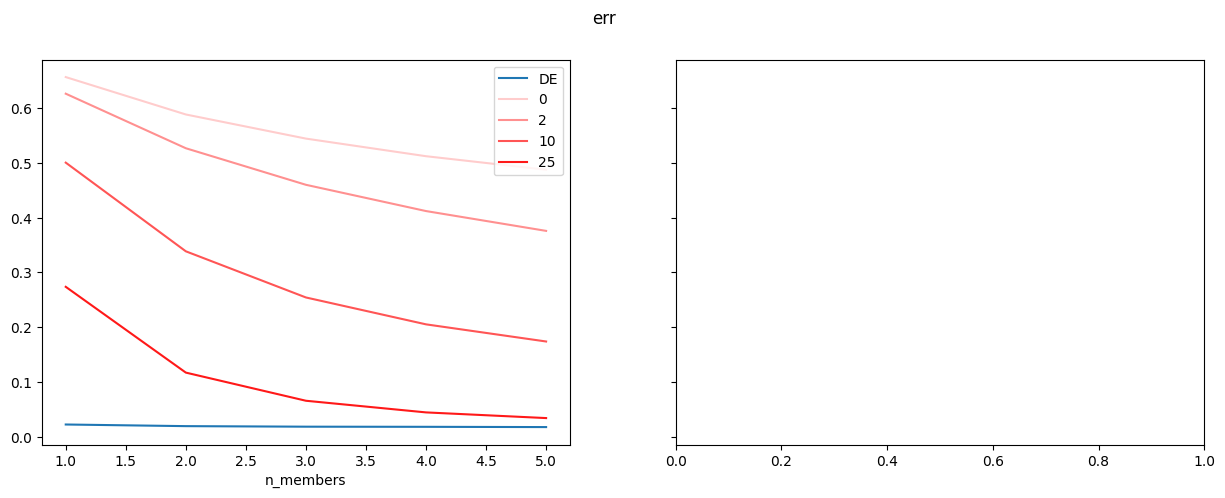

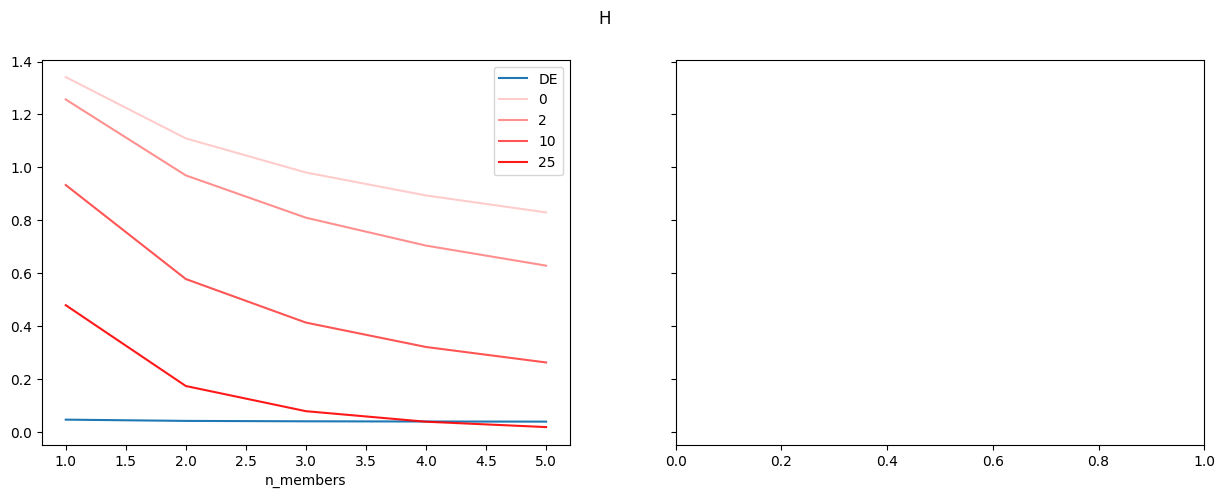

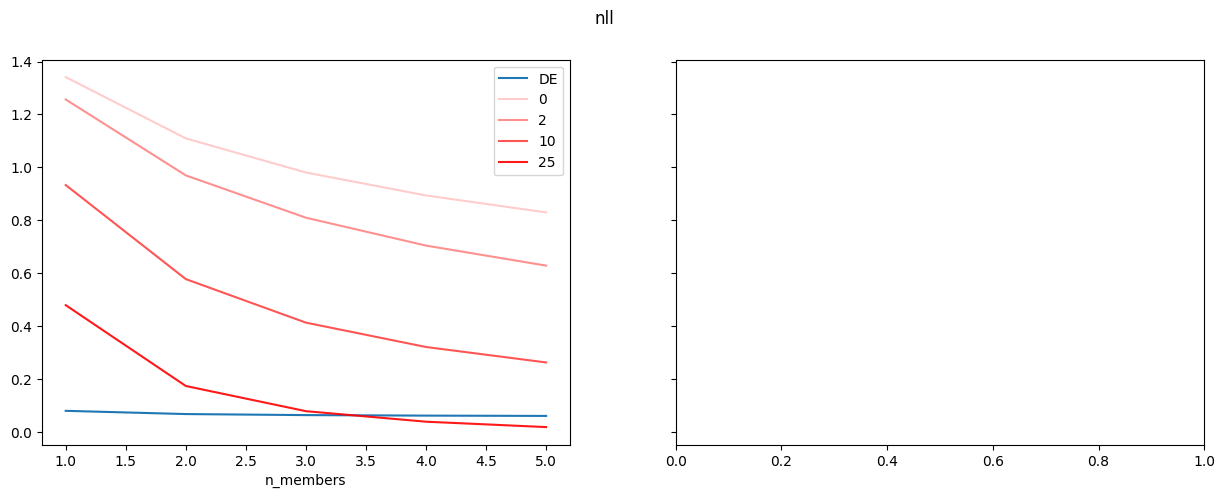

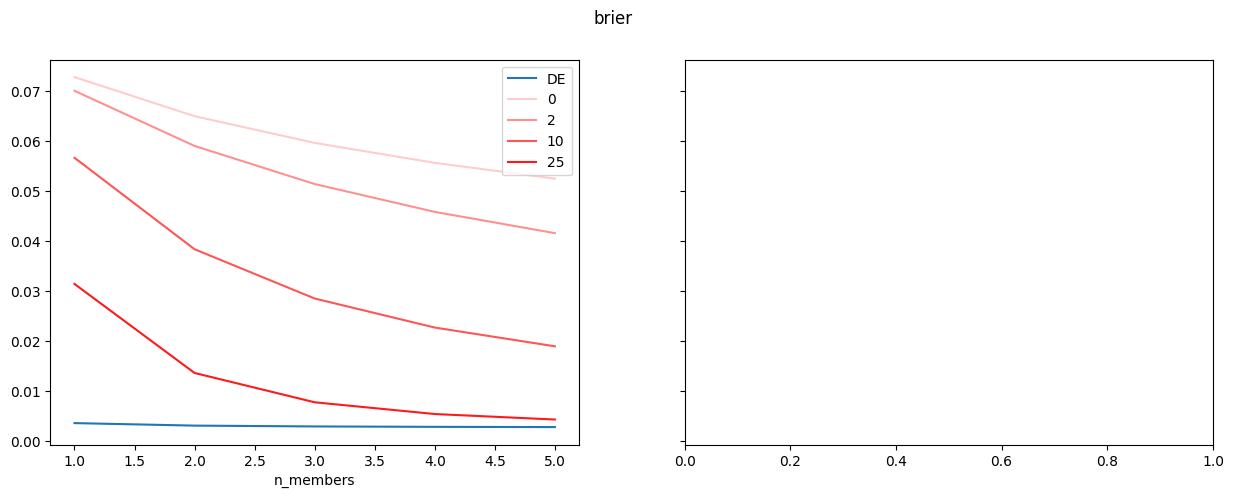

In [18]:
for metric in METRICS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

    finetune_epochs_experiment[metric]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    # finetune_epochs_experiment[metric]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

    ft_plot = np.linspace(0.2, 0.9, len(FINE_TUNE_EPOCHS))
    for i, ft in enumerate(FINE_TUNE_EPOCHS):
            finetune_epochs_experiment[metric]["mean"].loc[f'prod_model_0_0.5_pretrained_softmax_finetuned{ft}', :].plot(
                                                                       ax=axes[0], 
                                                                       label=ft, 
                                                                       color="red", 
                                                                       alpha=ft_plot[i])
    
    fig.suptitle(metric)
    axes[0].legend()
    plt.show()

In [19]:
for model_name, model_type in [("ens_model_0", ens_model),  
                               ("prod_model_0_0.5_pretrained_softmax_finetuned0", prod_model)]:
    print("===============================================================")
    print(model_name)
    state = restore_checkpoint(f'dynNN_redux/{model_name}', 1)
    
    pred_fun = partial(
            model_type.apply,
            {"params": state['params'], **state['model_state']},
            train=False,
            method=model_type.ens_logits
        )
    logits = jax.vmap(
        pred_fun, axis_name="batch"
    )(jnp.array(X_test))
    
    
    softmax_error = jax.vmap(categorical_err)(logits, jnp.array(y_test)).mean()
    ovr_error = jax.vmap(ovr_err)(logits, jnp.array(y_test)).mean()
    
    print(f"Sofmax error: {softmax_error:.4f}")
    print(f"OVR error: {ovr_error:.4f}")

ens_model_0
Sofmax error: 0.0184
OVR error: 0.4872
prod_model_0_0.5_pretrained_softmax_finetuned0
Sofmax error: 0.0184
OVR error: 0.4872


In [21]:
state_de = restore_checkpoint(f'dynNN_redux/ens_model_0', 1)
state_poe = restore_checkpoint(f'dynNN_redux/prod_model_0_0.5_pretrained_softmax_finetuned0', 1)

In [24]:
STATE_PARAM = "params"
# STATE_PARAM = "model_state"
for net, net_dict in state_de[STATE_PARAM].items():
    if isinstance(net_dict, np.ndarray):
            assert (net_dict == state_poe[STATE_PARAM][net]).all()
    else:
        for layer, layer_dict in net_dict.items():
            if isinstance(layer_dict, np.ndarray):
                assert (layer_dict == state_poe[STATE_PARAM][net][layer]).all()
            else:
                for array, array_dict in layer_dict.items():
                    if isinstance(array_dict, np.ndarray):
                        assert ((array_dict == state_poe[STATE_PARAM][net][layer][array])).all()
                    else:
                        for array2, array2_dict in array_dict.items():
                            if isinstance(array2_dict, np.ndarray):
                                assert ((array2_dict == state_poe[STATE_PARAM][net][layer][array][array2])).all()
                            else:
                                for array3, array3_dict in array2_dict.items():
                                    assert ((array3_dict == state_poe[STATE_PARAM][net][layer][array][array2][array3])).all()